## Predict CTAPs for flow data
## Fan Zhang
## 2021-08-11

In [177]:
suppressPackageStartupMessages({
library(knitr)
library(ggplot2)
library(mixtools)
library(dplyr)
library(janitor)
library(magrittr)
library(patchwork)
library(readxl)
library(reshape2)
library(MASS)
library(RColorBrewer)
library(viridis)
library(ggplot2)
library(ggrepel)
require(gdata)
library(stringr)
library(data.table)
library(ggpubr)
library(gridExtra)
library(reshape)
library(scico)
library(dplyr)
library(patchwork)
library(magrittr)
library(cetcolor)
library(seriation)
library(data.table)
library(pheatmap)
library(ggbeeswarm)
})

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

In [2]:
theme_clean <- function(base_size = 20, base_family = "") {
  theme_classic(
    base_size = base_size, base_family = base_family
  ) %+replace%
    theme(
#        legend.position = "none",
        legend.position="bottom",
      #axis.line = element_line(size = 0),
      axis.text.x = element_text(color="black"), 
      axis.text.y = element_text(color="black"), 
      axis.ticks = element_line(size = 0.2),
      strip.background = element_rect(size = 0),
      panel.background = element_rect(
        size = 0.4, color = "black"
      ),
      axis.line = element_blank()
    )
}

In [4]:
meta_colors = list(

    "cell_type" = c(
        "B cell/plasma cell" = "#FDBF6F",
        "DC" = "#CAB2D6",
        "Fibroblast" = "#08519C",
        "Endothelial cell" = "#A6CEE3",
        "Macrophage" = "#6A3D9A",
        "T cell" = "#B2DF8A",
        "NK" = "#33A02C"
    ),

    "new_class" = c(
        "M" = "#9E0142",
        "T + M" = "#F46D43",
        "T + B" = "#FEE08B",
        "T + F" = "#E6F598",
        "F" = "#ABDDA4",
        "E + F + M" = "#66C2A5"
    ),

    
    "Disease" = c( 
        "Leukocyte-poor RA" = "tan",
        "Leukocyte-rich RA" = "tomato",
        "OA" = "darkgrey"
    ),
    
    "treatment" = c(
#          “treatment naive = 1, methotrexate failure =2 and TNF failure = 3;
        "1" = "grey",
        "2" = "#8DD3C7", # green
        "3" = "#BC80BD"   # purple
    )

)


# Load the results

In [5]:
meta_all <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/fine_cluster_7cell_types_2021-03-22.rds")

# Visualize cluster abundance

In [6]:
# Return a dataframe where 'col1' and 'col2' are factors with levels in order.
seriate_cols <- function(d, col1, col2, value.var = "percent") {
  mat <- dcast(
    data = d,
    formula = as.formula(sprintf("%s ~ %s", col1, col2)),
    value.var = value.var
  )
  rownames(mat) <- mat[[1]]
  mat[[1]] <- NULL
  mat <- as.matrix(mat)
  mat[is.na(mat)] <- 0
  mat_order <- seriate(mat, method = "BEA_TSP")
  d[[col1]] <- factor(as.character(d[[col1]]), rownames(mat)[mat_order[[1]]])
  d[[col2]] <- factor(as.character(d[[col2]]), colnames(mat)[mat_order[[2]]])
  return(d)
}

In [7]:
d <- melt(table(meta_all$sample, meta_all$cell_type))
colnames(d) <- c("donor", "cell_type", "cells")
dim(d)

[1] 492   3

In [8]:
# 'percent_donor'
# is the percent of the donor's cells in this cluster,
# where all four cell types are pooled together.
d %<>% group_by(donor) %>% mutate(percent_donor = 100 * cells / sum(cells))

# 'percent_donor_cell_type'
# is the percent of the donor's cells in this cluster,
# where each cell type is 100%
d %<>% group_by(donor, cell_type) %>% mutate(percent_donor_cell_type = 100 * cells / sum(cells))

d <- d[complete.cases(d), ]
dim(d)
# head(d)

[1] 485   5

In [9]:
oa_sample <- c("BRI-399", "BRI-438", "BRI-442", "BRI-456", "BRI-477", "BRI-487", "BRI-517", "BRI-523", "BRI-587", "BRI-609")
length(oa_sample)

[1] 10

In [11]:
sum(d[which(d$donor == "BRI-399"),]$percent_donor)

[1] 100

In [12]:
# Cell type abundance matrix on both baseline and second samples, which will be used to calculate eucledien distance between random points to the first biopsies
d_RA <- d[-which(d$donor %in% oa_sample),]
d_RA$donor <- as.character(d_RA$donor)
length(table(d$donor))
mat <- dcast(data = d_RA, formula = donor ~ cell_type, value.var = "percent_donor")
rownames(mat) <- mat[[1]]
mat[[1]] <- NULL
mat <- as.matrix(mat)
mat[is.na(mat)] <- 0
dim(mat)
mat[1:4,]
sum(mat[1,])

[1] 82

Warning message in dcast(data = d_RA, formula = donor ~ cell_type, value.var = "percent_donor"):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(d_RA). In the next version, this warning will become an error."


[1] 73  6

,B cell/plasma cell,Endothelial cell,Fibroblast,Myeloid,NK,T cell
BRI-401,0.6915629,5.232826,5.578608,72.45274,1.6366989,14.407561
BRI-403,18.3521713,1.279001,8.001190,58.92326,1.8738846,11.570494
BRI-405,1.7804154,18.298714,35.212661,40.25717,0.1978239,4.253215
BRI-407,7.5681905,5.071072,2.228198,28.15982,2.6892048,54.283519


[1] 100

# PCA on baseline RA samples

In [13]:
second <- c("BRI-629", "BRI-633R", "BRI-637R") # Remove repeated samples
d_RA <- d[-which(d$donor %in% c(oa_sample, second)),]
d_RA$donor <- as.character(d_RA$donor)
length(table(d_RA$donor))
mat <- dcast(data = d_RA, formula = donor ~ cell_type, value.var = "cells") # "cells"
rownames(mat) <- mat[[1]]
mat[[1]] <- NULL
mat <- as.matrix(mat)
mat[is.na(mat)] <- 0

d_second <- d[which(d$donor %in% second),]
mat_second <- dcast(data = d_second, formula = donor ~ cell_type, value.var = "cells") # "cells"
rownames(mat_second) <- mat_second[[1]]
mat_second[[1]] <- NULL
mat_second <- as.matrix(mat_second)
mat_second[is.na(mat_second)] <- 0
mat_second

[1] 70

Warning message in dcast(data = d_RA, formula = donor ~ cell_type, value.var = "cells"):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(d_RA). In the next version, this warning will become an error."
Warning message in dcast(data = d_second, formula = donor ~ cell_type, value.var = "cells"):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(d_second). In the next version, this warning will become an error."


,B cell/plasma cell,Endothelial cell,Fibroblast,Myeloid,NK,T cell
BRI-629,66,72,271,441,31,59
BRI-633R,17,18,26,48,13,60
BRI-637R,0,196,213,90,7,65


In [14]:
scale_rows <- function(x) t(scale(t(x)))
pca <- summary(prcomp(x = scale_rows(mat), scale = TRUE))
pca_RA <- as.data.frame(pca$x)
pca_RA$donor <- rownames(pca_RA)

In [15]:
# Load the previous RA categories on 70 samples
before <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/d_pca_category_2021-04-14.rds")
dim(before)
before <- before[, c("donor", "new_class")]
table(before$new_class)
pca_RA <- merge(pca_RA, before, by = "donor", all.x = TRUE)
dim(pca_RA)
pca_RA[1:4,]


[1] 70  8


E + F + M         F         M     T + B     T + F     T + M 
        7        11        18        14         8        12 

[1] 70  8

,donor,PC1,PC2,PC3,PC4,PC5,PC6,new_class
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BRI-401,-0.3934239,1.6318514,-0.04312627,1.40125827,-1.3260909,2.142156e-16,M
2,BRI-403,-0.1555005,1.5124694,1.25829232,1.08994564,-1.0840242,4.823097e-16,M
3,BRI-405,-2.5729436,0.2745722,0.29907376,0.47199955,-0.3702111,9.262540e-16,E + F + M
4,BRI-407,1.2102972,0.6458329,-0.58902004,-0.05273338,0.1573147,-7.847622e-16,T + M


In [16]:
pca_RA$cluster <- pca_RA$new_class
pca_RA$neg_PC2 <- -pca_RA$PC2

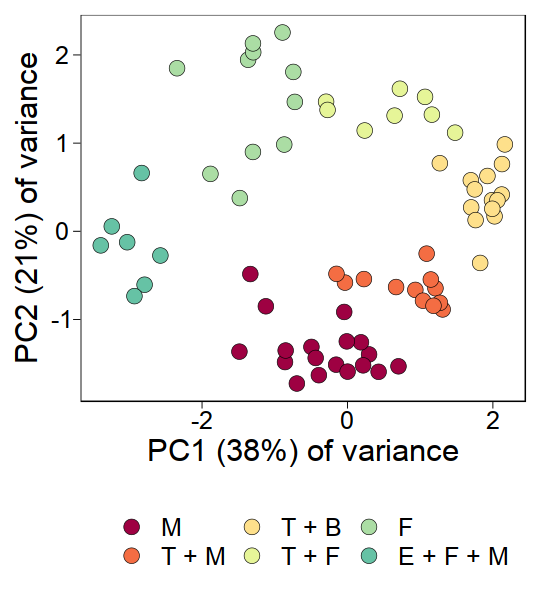

In [17]:
options(repr.plot.width = 4.5, repr.plot.height = 5)
ggplot(pca_RA, aes(PC1, -PC2, fill = new_class)) +
geom_point(size = 4, shape = 21, stroke = 0.2) +
scale_fill_manual(values = meta_colors$new_class, name = "") + 
labs(
  x = sprintf("PC1 (%.0f%%) of variance", 100 * pca$importance[2,1]),
  y = sprintf("PC2 (%.0f%%) of variance", 100 * pca$importance[2,2])
) +
theme_clean(base_size = 18) 
ggsave(file = paste("baseline_PCA", ".pdf", sep = ""), width = 4.5, height = 5, dpi = 300)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


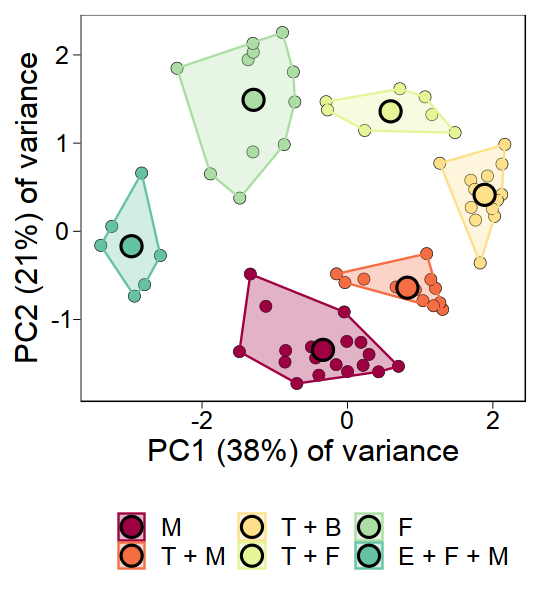

In [21]:
options(repr.plot.width = 4.5, repr.plot.height = 5)
ggscatter(
  pca_RA, x = "PC1", y = "neg_PC2", 
  fill = "new_class", palette = "npg", ellipse = TRUE, ellipse.type = "convex",  # convex, euclid
  size = 3, shape = 21, stroke = 0.2, legend = "right", ellipse.alpha = 0.3, 
  ggtheme = theme_bw()
  ) +
  stat_mean(aes(fill = new_class), size = 5, shape = 21, stroke = 1) +  # Add cluster centroid
  scale_color_manual(values = meta_colors$new_class, name = "") +
  scale_fill_manual(values = meta_colors$new_class, name = "") +
    labs(
      x = sprintf("PC1 (%.0f%%) of variance", 100 * pca$importance[2,1]),
      y = sprintf("PC2 (%.0f%%) of variance", 100 * pca$importance[2,2])
    ) +
    theme_clean(base_size = 18) 
ggsave(file = paste("baseline_PCA_centroid_1", ".pdf", sep = ""), width = 4.5, height = 5, dpi = 300)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



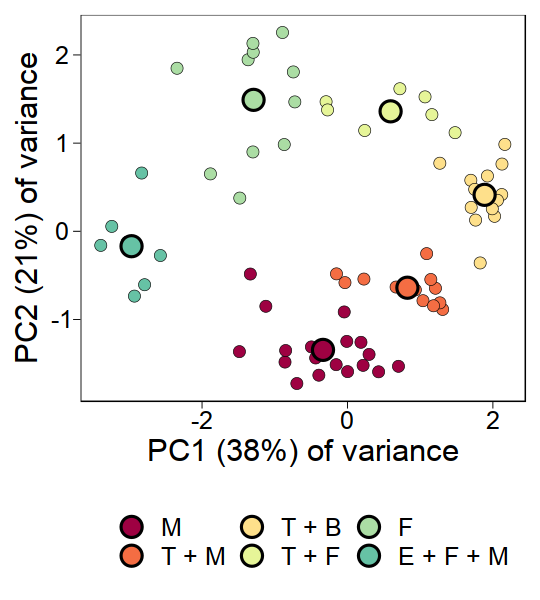

In [29]:
pca_RA$cluster <- pca_RA$new_class
pca_RA$neg_PC2 <- -pca_RA$PC2
options(repr.plot.width = 4.5, repr.plot.height = 5)
ggscatter(
  pca_RA, x = "PC1", y = "neg_PC2", 
  fill = "new_class", palette = "npg", ellipse = FALSE, # ellipse.type = "convex",  # convex, euclid
  size = 3, shape = 21, stroke = 0.2, legend = "right", ellipse.alpha = 0.3, 
  ggtheme = theme_bw()
  ) +
  stat_mean(aes(fill = new_class), size = 5, shape = 21, stroke = 1) +  # Add cluster centroid
  scale_color_manual(values = meta_colors$new_class, name = "") +
  scale_fill_manual(values = meta_colors$new_class, name = "") +
    labs(
      x = sprintf("PC1 (%.0f%%) of variance", 100 * pca$importance[2,1]),
      y = sprintf("PC2 (%.0f%%) of variance", 100 * pca$importance[2,2])
    ) +
    theme_clean(base_size = 18) 
ggsave(file = paste("baseline_PCA_centroid_2", ".pdf", sep = ""), width = 4.5, height = 5, dpi = 300)

# New data points: flow

In [357]:
# Load Helena's flow strategy - updated NK column
flow <- read.xls("/data/srlab2/fzhang/results/2021_02_09_Amp_RA_Phase2_Figure2/210817NewR1gatestats.xls", sheet = 1, header = TRUE)
colnames(flow) <- c("AMP_patient_ID", "Monocytes_among_live", "B_cells_among_live", "NK_cells_among_live", "NK_cells_among_live_old", 
                    "T_cells_among_live", "CD4Tcells",	"CD8Tcell",  "Endothelial_cells_among_live", "Fibroblasts_among_live",
                    "Lining_fibro_among_live",	"sublining_fibro_among_live", "Pericytes_among_live")
rownames(flow) <- flow[, 1]
flow <- flow[, -1]

flow$Stromal_cells_among_live <- flow$Fibroblasts_among_live + flow$Pericytes_among_live
flow$Myeloid_among_live <- flow$Monocytes_among_live + flow$DCs_among_live
flow <- flow[, c("B_cells_among_live", "Endothelial_cells_among_live", "Stromal_cells_among_live", "Myeloid_among_live", "NK_cells_among_live", "T_cells_among_live")]
colnames(flow) <- c("B cell/plasma cell", "Endothelial cell", "Fibroblast", "Myeloid", "NK", "T cell")
flow[1:4,]


,B cell/plasma cell,Endothelial cell,Fibroblast,Myeloid,NK,T cell
300_0307,0.0924,0.0231,0.2175,0.338,0.0656,0.235
300_0392,0.2270,0.0101,0.0549,0.115,0.0620,0.516
300_0268,0.0238,0.0280,0.4043,0.229,0.0492,0.182
301_0166,0.1070,0.0528,0.4348,0.120,0.0510,0.216


In [19]:
pca_flow <- scale(scale_rows(flow), pca$center, pca$scale) %*% pca$rotation 
pca_flow <- as.data.frame(pca_flow)
pca_flow$donor <- rownames(pca_flow)
pca_flow$new_class <- NA
pca_flow$cluster <- pca_flow$new_class
pca_flow$neg_PC2 <- -pca_flow$PC2
pca_flow[1:4,]

,PC1,PC2,PC3,PC4,PC5,PC6,donor,new_class,cluster,neg_PC2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>
300_0307,-0.4798785,1.1273877,1.1144816,0.5283102,1.0835770,-1.557261e-17,300_0307,NA,NA,-1.1273877
300_0392,2.1220236,-0.3253208,0.2611908,-0.4193748,-0.1340842,-3.579290e-16,300_0392,NA,NA,0.3253208
300_0268,-1.1365345,-0.7567053,0.3209088,1.2459131,0.7727989,2.397956e-16,300_0268,NA,NA,0.7567053
301_0166,-0.8594236,-1.7075482,0.8188311,0.3794457,0.9017996,3.492813e-16,301_0166,NA,NA,1.7075482


In [20]:
pca_RA <- rbind(pca_RA, pca_flow)
pca_RA$label <- rep("Single cell", nrow(pca_RA))
pca_RA[which(pca_RA$donor %in% rownames(pca_flow)),]$label <- "Flow"
table(pca_RA$label)


       Flow Single cell 
         20          70 

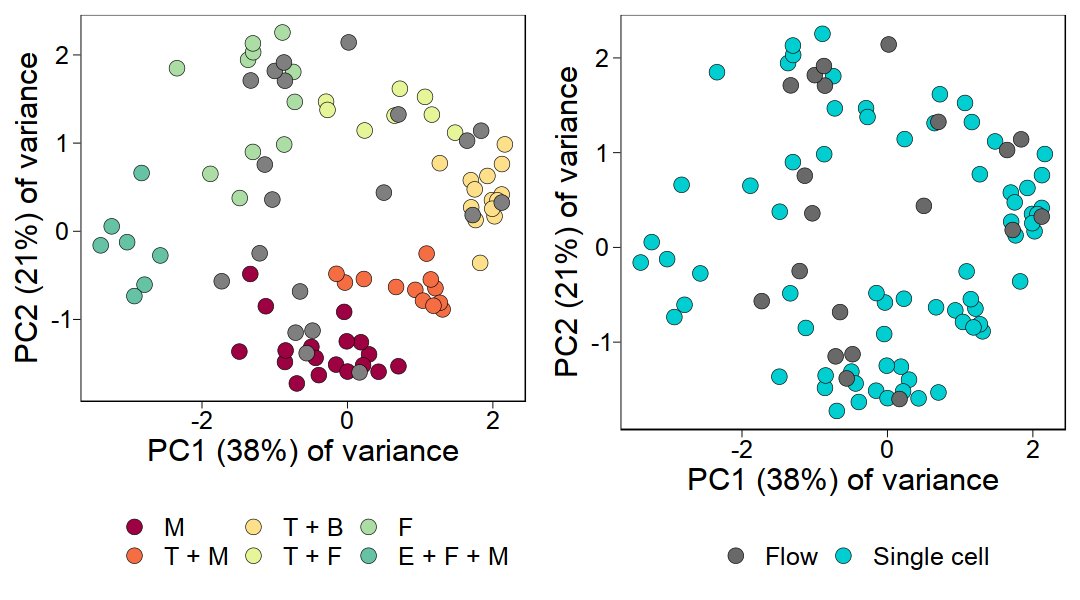

In [19]:
# Helena's flow strategy 
p1 <- ggplot(pca_RA, aes(PC1, -PC2, fill = label)) +
    geom_point(size = 4, shape = 21, stroke = 0.2) +
    scale_fill_manual(values = c("dimgrey", "darkturquoise"), name = "") + 
    labs(
      x = sprintf("PC1 (%.0f%%) of variance", 100 * pca$importance[2,1]),
      y = sprintf("PC2 (%.0f%%) of variance", 100 * pca$importance[2,2])
    ) +
    theme_clean(base_size = 18) 


p2 <- ggplot(pca_RA, aes(PC1, -PC2, fill = new_class)) +
    geom_point(size = 4, shape = 21, stroke = 0.2) +
    scale_fill_manual(values = meta_colors$new_class, name = "") + 
    labs(
      x = sprintf("PC1 (%.0f%%) of variance", 100 * pca$importance[2,1]),
      y = sprintf("PC2 (%.0f%%) of variance", 100 * pca$importance[2,2])
    ) +
    theme_clean(base_size = 18) 

options(repr.plot.width = 9, repr.plot.height = 5)
all <- ggarrange(p2, p1, ncol = 2, nrow = 1, align = "v")
all
ggsave(file = paste("project_flow_onto_PCA", ".pdf", sep = ""), all, width = 9, height = 5, dpi = 300)

# Mahalanobis distances

In [21]:
x <- pca_RA[, c("PC1", "neg_PC2", "PC3", "PC4", "PC5")]

ix_class <- pca_RA$new_class == "E + F + M"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_EFM <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_EFM <- sqrt(pca_RA$maha_sq_EFM)

ix_class <- pca_RA$new_class == "F"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_F <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_F <- sqrt(pca_RA$maha_sq_F)

ix_class <- pca_RA$new_class == "T + B"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_TB <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_TB <- sqrt(pca_RA$maha_sq_TB)

ix_class <- pca_RA$new_class == "T + F"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_TF <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_TF <- sqrt(pca_RA$maha_sq_TF)

ix_class <- pca_RA$new_class == "T + M"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_TM <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_TM <- sqrt(pca_RA$maha_sq_TM)

ix_class <- pca_RA$new_class == "M"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_M <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_M <- sqrt(pca_RA$maha_sq_M)

In [22]:
# Take the distance between flow samples to centroids
# pca_RA_mah <- pca_RA[which(pca_RA$donor %in% gsub("_", "-", rownames(pca_flow)) ),]
pca_RA_mah <- pca_RA[which(pca_RA$donor %in% rownames(pca_flow) ),]
pca_RA_mah <- pca_RA_mah[, c("maha_EFM", "maha_F", "maha_TB", "maha_TF", "maha_TM", "maha_M")]
pca_RA_mah <- melt(pca_RA_mah, measure.vars = c("maha_EFM","maha_F","maha_TB","maha_TF","maha_TM","maha_M"), variable.name = "maha_class" , value.name = "maha")
pca_RA_mah$donor <- rep(rownames(pca_flow), 6)
pca_RA_mah$donor <- gsub("_", "-", pca_RA_mah$donor)
dim(pca_RA_mah)
pca_RA_mah[1:4,]

[1] 120   3

,variable,value,donor
,<fct>,<dbl>,<chr>
1,maha_EFM,13.745110,300-0307
2,maha_EFM,28.080315,300-0392
3,maha_EFM,2.474993,300-0268
4,maha_EFM,7.803716,301-0166


In [6]:
baseline <- read.xls("/data/srlab1/public/srcollab/AMP_Phase_2/clinical_data/metadata_clin_donor_singlecell.xlsx", sheet = 1, header = TRUE) 
baseline <- baseline[, c("subject_id", "mRNA_run")]
baseline <- baseline[which(baseline$subject_id %in% unique(pca_RA_mah$donor)),]
colnames(baseline)[2] <- "donor"
baseline <- merge(x = baseline, y = before, by = "donor", all.x = TRUE)
dim(baseline)

pca_RA_mah$subject_id <- pca_RA_mah$donor
pca_RA_mah <- merge(x = pca_RA_mah, y = baseline, by = "subject_id", all.x = TRUE)
dim(pca_RA_mah)
# Synchronize maha_XXX to XXX
pca_RA_mah$variable2 <- substring(pca_RA_mah$variable, 6)
pca_RA_mah$variable2[which(pca_RA_mah$variable2 == "EFM")] <- "E + F + M"
pca_RA_mah$variable2[which(pca_RA_mah$variable2 == "TB")] <- "T + B"
pca_RA_mah$variable2[which(pca_RA_mah$variable2 == "TM")] <- "T + M"
pca_RA_mah$variable2[which(pca_RA_mah$variable2 == "TF")] <- "T + F"
pca_RA_mah$highlight <- as.character(pca_RA_mah$new_class == pca_RA_mah$variable2) # Highlight the original assigned single-cell CTAP for each overlapped patient
pca_RA_mah[1:4,]
table(pca_RA_mah$highlight)
table(pca_RA_mah$new_class)

In [7]:

plot_s <- unique(pca_RA_mah[order(pca_RA_mah$new_class),]$subject_id) # Plot 5 either OA or failed QC samples who don't have original CTAPs in the last
plot_s <- plot_s[c(1,3:14,2,15:length(plot_s))]
myplots <- list()
for (i in 1:length(plot_s)) {
   this_s <- plot_s[i] 
   ind <- paste("p", i, sep = "")
   ind <- ggplot(pca_RA_mah[which(pca_RA_mah$subject_id == this_s),], 
                 aes(x=reorder(variable, -value), y=value, fill = highlight)) + 
        geom_bar(stat = "identity", width = 0.8) +
        coord_flip() +
        labs(x = NULL, y = NULL, title = this_s) +
        scale_fill_manual(values = c("dimgrey", "red"), name = "") + 
        theme_classic(base_size = 16) +
        theme(
            legend.position = "none",
            axis.text.x = element_text(color = "black"), #  hjust = 1, angle = 45
            axis.text.y = element_text(color = "black"),
            panel.grid = element_blank()
        )
   myplots[[i]] <- ind
    
}

options(repr.plot.height = 12, repr.plot.width = 14)
p <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("maha_flow_onto_PCA", ".pdf", sep = ""), p, width = 14, height = 12, dpi = 300)

Var1,Freq,percent
<fct>,<int>,<dbl>
FALSE,2,13.33333
TRUE,13,86.66667


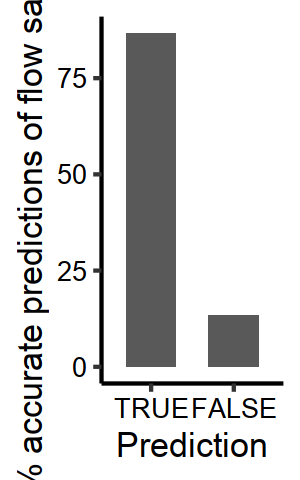

In [176]:
sum_plot <- as.data.frame(table(pca_RA_mah_predict$compare))
sum_plot$percent <- 100 * sum_plot$Freq / nrow(pca_RA_mah_predict)
sum_plot

options(repr.plot.height = 4, repr.plot.width = 2.5)
ggplot(data = sum_plot, aes(x = reorder(Var1, -percent), y = percent)) +
  geom_bar(stat = "identity",  width = 0.6,
           position=position_dodge(width = 0.5)
          )+
#    scale_y_continuous(labels = scales::percent) +
   labs(x = "Prediction", y = "% accurate predictions of flow samples") +
   theme_classic(base_size =20) +
   theme(
            legend.position = "none",
            axis.text.x = element_text(color = "black"), #  hjust = 1, angle = 45
            axis.text.y = element_text(color = "black"),
            panel.grid = element_blank()
        )
ggsave(file = paste("maha_flow_onto_PCA_accurary", ".pdf", sep = ""), width = 2.5, height = 4, dpi = 300)

# Project new data on PCA loadings

In [8]:
# project new data onto the PCA space
pca_second <- scale(scale_rows(mat_second), pca$center, pca$scale) %*% pca$rotation 
pca_second <- as.data.frame(pca_second)
pca_second$donor <- rownames(pca_second)
pca_second$new_class <- NA
pca_second$cluster <- pca_second$new_class
pca_second$neg_PC2 <- -pca_second$PC2
pca_second

pca_RA <- rbind(pca_RA, pca_second)
pca_RA$first_second <- rep("No", nrow(pca_RA))
pca_RA[which(pca_RA$donor %in% second),]$first_second <- "second"
pca_RA[which(pca_RA$donor %in% c("BRI-627", "BRI-631", "BRI-635")),]$first_second <- "first"
table(pca_RA$first_second)

# Mahalanobis distances: scale the contribution of individual variables to `D2 = (x - m)V -1(x - m)` the distance value according to the variability of each variable

D2 = (x - m)V-1(x - m)

In [177]:
x <- pca_RA[, c("PC1", "neg_PC2", "PC3", "PC4", "PC5")]

ix_class <- pca_RA$new_class == "E + F + M"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_EFM <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_EFM <- sqrt(pca_RA$maha_sq_EFM)

ix_class <- pca_RA$new_class == "F"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_F <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_F <- sqrt(pca_RA$maha_sq_F)

ix_class <- pca_RA$new_class == "T + B"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_TB <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_TB <- sqrt(pca_RA$maha_sq_TB)

ix_class <- pca_RA$new_class == "T + F"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_TF <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_TF <- sqrt(pca_RA$maha_sq_TF)

ix_class <- pca_RA$new_class == "T + M"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_TM <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_TM <- sqrt(pca_RA$maha_sq_TM)

ix_class <- pca_RA$new_class == "M"
ix_class <- ix_class[!is.na(ix_class)]
pca_RA$maha_sq_M <- mahalanobis(x = x, center = colMeans(x[ix_class,]), cov = cov(x[ix_class,]))
pca_RA$maha_M <- sqrt(pca_RA$maha_sq_M)

In [178]:
pca_RA[1:4,]
saveRDS(pca_RA, "pca_RA_maha_to_centroid.rds")

donor,PC1,PC2,PC3,PC4,PC5,PC6,new_class,cluster,neg_PC2,...,maha_sq_F,maha_F,maha_sq_TB,maha_TB,maha_sq_TF,maha_TF,maha_sq_TM,maha_TM,maha_sq_M,maha_M
BRI-401,-0.3934239,1.6318514,-0.04312627,1.40125827,-1.3260909,2.142156e-16,M,M,-1.6318514,...,3236.36310,56.889042,321.78451,17.938353,656.4309,25.62091,400.3469719,20.0086724,5.144871,2.268231
BRI-403,-0.1555005,1.5124694,1.25829232,1.08994564,-1.0840242,4.823097e-16,M,M,-1.5124694,...,4136.62512,64.316601,260.30794,16.134061,655.5301,25.60332,439.4849642,20.9638967,3.504452,1.872018
BRI-405,-2.5729436,0.2745722,0.29907376,0.47199955,-0.3702111,9.262540e-16,E + F + M,E + F + M,-0.2745722,...,41.84165,6.468512,628.29573,25.065828,298.8597,17.28756,672.5963226,25.9344621,16.428975,4.053267
BRI-407,1.2102972,0.6458329,-0.58902004,-0.05273338,0.1573147,-7.847622e-16,T + M,T + M,-0.6458329,...,4748.64034,68.910379,29.46932,5.428565,185.9127,13.63498,0.7182721,0.8475094,16.988322,4.121689


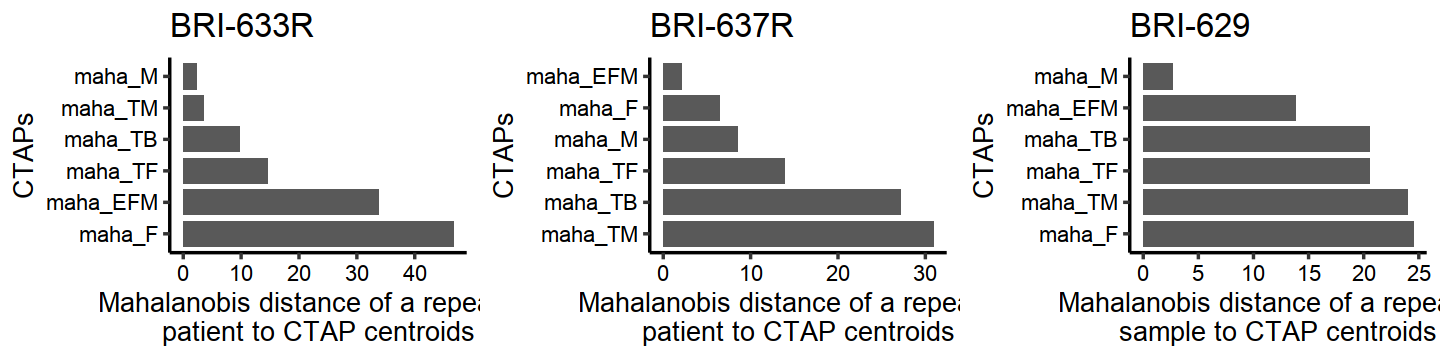

In [179]:
# "BRI-629" "BRI-633R" "BRI-637R" to each centroid
pca_RA_mah <- pca_RA[which(pca_RA$donor %in% c("BRI-629", "BRI-633R", "BRI-637R")),]
pca_RA_mah <- pca_RA_mah[, c("maha_EFM", "maha_F", "maha_TB", "maha_TF", "maha_TM", "maha_M")]
pca_RA_mah <- melt(pca_RA_mah, measure.vars = c("maha_EFM","maha_F","maha_TB","maha_TF","maha_TM","maha_M"), variable.name = "maha_class" , value.name = "maha")
pca_RA_mah$donor <- rep(c("BRI-629", "BRI-633R", "BRI-637R"), 6)

p1 <- ggplot(pca_RA_mah[which(pca_RA_mah$donor == "BRI-629"),], aes(x=reorder(variable, -value), y=value)) + 
        geom_bar(stat = "identity", width = 0.8) +
        coord_flip() +
        labs(x = "CTAPs", y = "Mahalanobis distance of a repeated \nsample to CTAP centroids", title = "BRI-629") +
        theme_classic(base_size = 16) +
        theme(
            legend.position = "none",
            axis.text.x = element_text(color = "black"), 
            axis.text.y = element_text(color = "black"),
            panel.grid = element_blank()
        )

p2 <- ggplot(pca_RA_mah[which(pca_RA_mah$donor == "BRI-633R"),], aes(x=reorder(variable, -value), y=value)) + 
        geom_bar(stat = "identity", width = 0.8) +
        coord_flip() +
        labs(x = "CTAPs", y = "Mahalanobis distance of a repeated \npatient to CTAP centroids", title = "BRI-633R") +
        theme_classic(base_size = 16) +
        theme(
            legend.position = "none",
            axis.text.x = element_text(color = "black"), 
            axis.text.y = element_text(color = "black"),
            panel.grid = element_blank()
        )

p3 <- ggplot(pca_RA_mah[which(pca_RA_mah$donor == "BRI-637R"),], aes(x=reorder(variable, -value), y=value)) + 
        geom_bar(stat = "identity", width = 0.8) +
        coord_flip() +
        labs(x = "CTAPs", y = "Mahalanobis distance of a repeated \npatient to CTAP centroids", title = "BRI-637R") +
        theme_classic(base_size = 16) +
        theme(
            legend.position = "none",
            axis.text.x = element_text(color = "black"), 
            axis.text.y = element_text(color = "black"),
            panel.grid = element_blank()
        )

options(repr.plot.width = 12, repr.plot.height = 3)
all <- ggarrange(p2, p3, p1, ncol = 3, nrow = 1, align = "v")
all
ggsave(file = paste("mah_to_centroids", ".pdf", sep = ""), all, width = 12, height = 3, dpi = 300)

# Calculate euclidean distance on PC space

In [736]:
# Calculate euclidean distance
dat_dist <- dist(as.matrix(pca_RA[, c("PC1", "PC2")]), method = "euclidean")
dat_dist <- as.matrix(dat_dist)
colnames(dat_dist) <- pca_RA$donor
rownames(dat_dist) <- pca_RA$donor
dim(dat_dist)
dat_dist[1:4, 1:4]

[1] 74 74

,BRI-399,BRI-401,BRI-403,BRI-405
BRI-399,0.000000,3.8198198,3.7982543,2.502334
BRI-401,3.819820,0.0000000,0.2738382,2.536924
BRI-403,3.798254,0.2738382,0.0000000,2.698891
BRI-405,2.502334,2.5369236,2.6988908,0.000000


In [737]:
# Point: "BRI-631"
n <- 10000
rand <- sample(seq(1:ncol(dat_dist)), n, replace = TRUE, prob = NULL)
perm_list_1 <- c()

for(i in rand) {
   temp <-  dat_dist["BRI-631", i]
   perm_list_1 <- c(perm_list_1, temp)
  }
observed_1 <- dat_dist["BRI-631", "BRI-633R"] 
observed_1
1 - sum(perm_list_1 > observed_1)/n


# Point: "BRI-627"
n <- 10000
rand <- sample(seq(1:ncol(dat_dist)), n, replace = TRUE, prob = NULL)
perm_list_2 <- c()

for(i in rand) {
   temp <-  dat_dist["BRI-627", i]
   perm_list_2 <- c(perm_list_2, temp)
  }
observed_2 <- dat_dist["BRI-627", "BRI-629"]  
observed_2
1 - sum(perm_list_2 > observed_2)/n


# Point: "BRI-635"
n <- 10000
rand <- sample(seq(1:ncol(dat_dist)), n, replace = TRUE, prob = NULL)
perm_list_3 <- c()

for(i in rand) {
   temp <-  dat_dist["BRI-635", i]
   perm_list_3 <- c(perm_list_3, temp)
  }
observed_3 <- dat_dist["BRI-635", "BRI-637R"] 
observed_3
1 - sum(perm_list_3 > observed_3)/n

[1] 0.8097231

[1] 0.1894

[1] 1.394393

[1] 0.1323

[1] 2.454619

[1] 0.2732

In [738]:
# Three baseline points
n <- 10000
rand_1 <- sample(seq(1:ncol(dat_dist)), n, replace = TRUE, prob = NULL)
rand_2 <- sample(seq(1:ncol(dat_dist)), n, replace = TRUE, prob = NULL)
rand_3 <- sample(seq(1:ncol(dat_dist)), n, replace = TRUE, prob = NULL)
perm_list_mean <- c()
perm_list_median <- c()

for(i in 1:n) {
   temp_1 <- dat_dist["BRI-631", rand_1[i]]
   temp_2 <- dat_dist["BRI-627", rand_2[i]]
   temp_3 <- dat_dist["BRI-635", rand_3[i]]
   mean_temp <- mean(c(temp_1, temp_2, temp_3))
   median_temp <- median(c(temp_1, temp_2, temp_3))
   perm_list_mean <- c(perm_list_mean, mean_temp)
   perm_list_median <- c(perm_list_median, median_temp)
  }


In [739]:
observed_1 <- dat_dist["BRI-631", "BRI-633R"] 
observed_2 <- dat_dist["BRI-627", "BRI-629"]  
observed_3 <- dat_dist["BRI-635", "BRI-637R"] 
observed_mean <- mean(c(observed_1, observed_2, observed_3))
observed_median <- median(c(observed_1, observed_2, observed_3))
observed_mean
observed_median

[1] 1.552912

[1] 1.394393

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 4)
hist(perm_list_mean, prob=T, main="Distances between randomly selected\n 1,0000 samples and three baseline samples", 
     xlab = paste0("Mean distance (d1, d2, d3) to baselines; p = ", 1 - sum(perm_list_mean > observed_mean)/n), breaks = 30)
lines(density(perm_list_mean, bw=.5),col="red",lwd=2) 
abline(v=observed_mean,lwd=2,col="red")
1 - sum(perm_list_mean > observed_mean)/n

hist(perm_list_median, prob=T, main="Distances between randomly selected\n 1,0000 samples and three baseline samples", 
     xlab = paste0("Mean distance (d1, d2, d3) to baselines; p = ", 1 - sum(perm_list_median > observed_median)/n), breaks = 30)
lines(density(perm_list_median, bw=.5),col="red",lwd=2) 
abline(v=observed_median,lwd=2,col="red")
1 - sum(perm_list_median > observed_median)/n

# Evaluate concordance between flow and CITE-seq on the same gates

In [67]:
# CTIE-seq
d_RA <- d[-which(d$donor %in% oa_sample),]
d_RA$donor <- as.character(d_RA$donor)
length(table(d$donor))
mat <- dcast(data = d_RA, formula = donor ~ cell_type, value.var = "percent_donor")
rownames(mat) <- mat[[1]]
mat[[1]] <- NULL
mat <- as.matrix(mat)
mat[is.na(mat)] <- 0
dim(mat)
mat[1:4,]
sum(mat[1,])

[1] 82

Warning message in dcast(data = d_RA, formula = donor ~ cell_type, value.var = "percent_donor"):
“The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(d_RA). In the next version, this warning will become an error.”


[1] 73  6

,B cell/plasma cell,Endothelial cell,Fibroblast,Myeloid,NK,T cell
BRI-401,0.6915629,5.232826,5.578608,72.45274,1.6366989,14.407561
BRI-403,18.3521713,1.279001,8.001190,58.92326,1.8738846,11.570494
BRI-405,1.7804154,18.298714,35.212661,40.25717,0.1978239,4.253215
BRI-407,7.5681905,5.071072,2.228198,28.15982,2.6892048,54.283519


[1] 100

In [39]:
# Load Helena's flow strategy
flow <- read.xls("/data/srlab2/fzhang/results/2021_02_09_Amp_RA_Phase2_Figure2/CTAPpopsfromflow210811.xls", sheet = 1, header = TRUE)
colnames(flow) <- c("AMP_patient_ID", "Monocytes_among_live", "B_cells_among_live", "T_cells_among_live","DCs_among_live", "NK_cells_among_live", "Endothelial_cells_among_live", "Fibroblasts_among_live", "Pericytes_among_live", "total")
rownames(flow) <- flow[, 1]
flow <- flow[, -1]

flow$Stromal_cells_among_live <- flow$Fibroblasts_among_live + flow$Pericytes_among_live
flow$Myeloid_among_live <- flow$Monocytes_among_live + flow$DCs_among_live
flow <- flow[, c("B_cells_among_live", "Endothelial_cells_among_live", "Stromal_cells_among_live", "Myeloid_among_live", "NK_cells_among_live", "T_cells_among_live")]
colnames(flow) <- c("B cell/plasma cell", "Endothelial cell", "Fibroblast", "Myeloid", "NK", "T cell")
rownames(flow) <- gsub("_", "-", rownames(flow))
flow <- 100 * flow
flow$subject_id <- rownames(flow)

# Convert subject_id to donor 
baseline <- read.xls("/data/srlab1/public/srcollab/AMP_Phase_2/clinical_data/metadata_clin_donor_singlecell.xlsx", sheet = 1, header = TRUE) 
baseline <- baseline[, c("subject_id", "mRNA_run")]
colnames(baseline)[2] <- "donor"

flow <- merge(flow, baseline, by = "subject_id")
rownames(flow) <- flow$donor
flow <- flow[, -1]
dim(flow)
flow[1:4,]

[1] 19  7

,B cell/plasma cell,Endothelial cell,Fibroblast,Myeloid,NK,T cell,donor
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
BRI-403,10.00,0.40,6.43,52.70,1.96,23.9,BRI-403
BRI-556,1.94,4.31,19.03,45.85,3.44,18.5,BRI-556
BRI-460,5.56,4.22,60.80,16.80,2.81,7.8,BRI-460
BRI-479,0.53,10.00,30.33,40.66,3.21,12.7,BRI-479


In [68]:
# Load Helena's flow strategy - updated NK column
flow <- read.xls("/data/srlab2/fzhang/results/2021_02_09_Amp_RA_Phase2_Figure2/210817NewR1gatestats.xls", sheet = 1, header = TRUE)
colnames(flow) <- c("AMP_patient_ID", "Monocytes_among_live", "B_cells_among_live", "NK_cells_among_live", "NK_cells_among_live_old", 
                    "T_cells_among_live", "CD4Tcells",	"CD8Tcell",  "Endothelial_cells_among_live", "Fibroblasts_among_live",
                    "Lining_fibro_among_live",	"sublining_fibro_among_live", "Pericytes_among_live")
rownames(flow) <- flow[, 1]
flow <- flow[, -1]

flow$Stromal_cells_among_live <- flow$Fibroblasts_among_live + flow$Pericytes_among_live
flow$Myeloid_among_live <- flow$Monocytes_among_live # + flow$DCs_among_live
flow <- flow[, c("B_cells_among_live", "Endothelial_cells_among_live", "Stromal_cells_among_live", "Myeloid_among_live", "NK_cells_among_live", "T_cells_among_live")]
colnames(flow) <- c("B cell/plasma cell", "Endothelial cell", "Fibroblast", "Myeloid", "NK", "T cell")
rownames(flow) <- gsub("_", "-", rownames(flow))
flow <- 100 * flow
flow$subject_id <- rownames(flow)

# Convert subject_id to donor 
baseline <- read.xls("/data/srlab1/public/srcollab/AMP_Phase_2/clinical_data/metadata_clin_donor_singlecell.xlsx", sheet = 1, header = TRUE) 
baseline <- baseline[, c("subject_id", "mRNA_run")]
colnames(baseline)[2] <- "donor"

flow <- merge(flow, baseline, by = "subject_id")
rownames(flow) <- flow$donor
flow <- flow[, -1]
dim(flow)
flow[1:4,]


[1] 19  7

,B cell/plasma cell,Endothelial cell,Fibroblast,Myeloid,NK,T cell,donor
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
BRI-403,10.20,0.41,5.52,50.4,2.09,24.10,BRI-403
BRI-556,2.00,4.42,17.86,39.6,3.81,19.00,BRI-556
BRI-460,5.66,4.32,60.44,16.8,2.84,7.83,BRI-460
BRI-479,0.54,10.20,29.70,40.0,3.46,12.80,BRI-479


In [69]:
# Merge
overlapped <- intersect(rownames(flow), rownames(mat))
length(overlapped)

flow <- flow[which(rownames(flow) %in% overlapped),]
mat <- mat[which(rownames(mat) %in% overlapped),]

flow <- flow[order(match(rownames(flow), rownames(mat))), ]
all(rownames(flow) == rownames(mat))

colnames(flow) <- paste0("flow_", colnames(flow), sep = "")
colnames(mat) <- paste0("singlecell_", colnames(mat), sep = "")
both <- cbind(flow, mat)
both$donor <- rownames(both)
dim(both)

both <- merge(both, baseline, by = "donor")
both[1:4,]

[1] 15

[1] TRUE

[1] 15 14

,donor,flow_B cell/plasma cell,flow_Endothelial cell,flow_Fibroblast,flow_Myeloid,flow_NK,flow_T cell,flow_donor,singlecell_B cell/plasma cell,singlecell_Endothelial cell,singlecell_Fibroblast,singlecell_Myeloid,singlecell_NK,singlecell_T cell,subject_id
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,BRI-401,0.26,1.83,14.76,55.20,1.31,17.6,BRI-401,0.6915629,5.232826,5.578608,72.45274,1.636699,14.40756,300-0302
2,BRI-403,10.20,0.41,5.52,50.40,2.09,24.1,BRI-403,18.3521713,1.279001,8.001190,58.92326,1.873885,11.57049,300-0150
3,BRI-415,25.00,1.37,16.16,5.02,3.41,41.9,BRI-415,24.1976635,2.376796,12.380824,10.74258,2.645361,47.65677,300-1933
4,BRI-427,2.68,1.14,52.39,10.10,8.86,17.9,BRI-427,4.2386735,4.869220,45.691266,19.44185,6.667445,19.09155,300-0414


In [97]:
p1 <- ggscatter(both, y = "flow_B cell/plasma cell", x = "singlecell_B cell/plasma cell",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "black",
                            fill = "lightgray"),
          size = 4, shape = 21, stroke = 1.5, fill = "highlight",
          label = "subject_id", repel = TRUE
          )+
  scale_fill_manual(values = c("grey", "red"), name = "") + 
  stat_cor(method = "pearson", size = 7, label.y = 25) +
  theme_classic(base_size = 25) 

p2 <- ggscatter(both, y = "flow_Endothelial cell", x = "singlecell_Endothelial cell",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "black",
                            fill = "lightgray"),
          size = 4, shape = 21, stroke = 1.5, fill = "highlight",
          label = "subject_id", repel = TRUE
          )+
  scale_fill_manual(values = c("grey", "red"), name = "") + 
  stat_cor(method = "pearson", size = 7) +
  theme_classic(base_size = 25) 


p3 <- ggscatter(both, y = "flow_Fibroblast", x = "singlecell_Fibroblast",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "black",
                            fill = "lightgray"),
          size = 4, shape = 21, stroke = 1.5, fill = "highlight",
          label = "subject_id", repel = TRUE
          )+
  scale_fill_manual(values = c("grey", "red"), name = "") + 
  stat_cor(method = "pearson", size = 7, label.y = 80) +
  theme_classic(base_size = 25) 


p4 <- ggscatter(both, y = "flow_Myeloid", x = "singlecell_Myeloid",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "black",
                            fill = "lightgray"),
          size = 4, shape = 21, stroke = 1.5, fill = "highlight",
          label = "subject_id", repel = TRUE
          )+
  scale_fill_manual(values = c("grey", "red"), name = "") + 
  stat_cor(method = "pearson", size = 7, label.y = 65) +
  theme_classic(base_size = 25) 

p5 <- ggscatter(both, y = "flow_NK", x = "singlecell_NK",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "black",
                            fill = "lightgray"),
          size = 4, shape = 21, stroke = 1.5, fill = "highlight",
          label = "subject_id", repel = TRUE
          )+
  scale_fill_manual(values = c("grey", "red"), name = "") + 
  stat_cor(method = "pearson", size = 7, label.y = 8.5) +
  theme_classic(base_size = 25) 

p6 <- ggscatter(both, y = "flow_T cell", x = "singlecell_T cell",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "black",
                            fill = "lightgray"),
          size = 4, shape = 21, stroke = 1.5, fill = "highlight",
          label = "subject_id", repel = TRUE
          )+
  scale_fill_manual(values = c("grey", "red"), name = "") + 
  stat_cor(method = "pearson", size = 7, label.y = 65) +
  theme_classic(base_size = 25) 


# options(repr.plot.width = 40, repr.plot.height = 6)
# all <- ggarrange(p1, p2, p3, p4, p5, p6, ncol = 6, nrow = 1, align = "v")
# all
# ggsave(file = paste("ctaps_vs_flow", ".pdf", sep = ""), all, width = 40, height = 6, dpi = 300)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



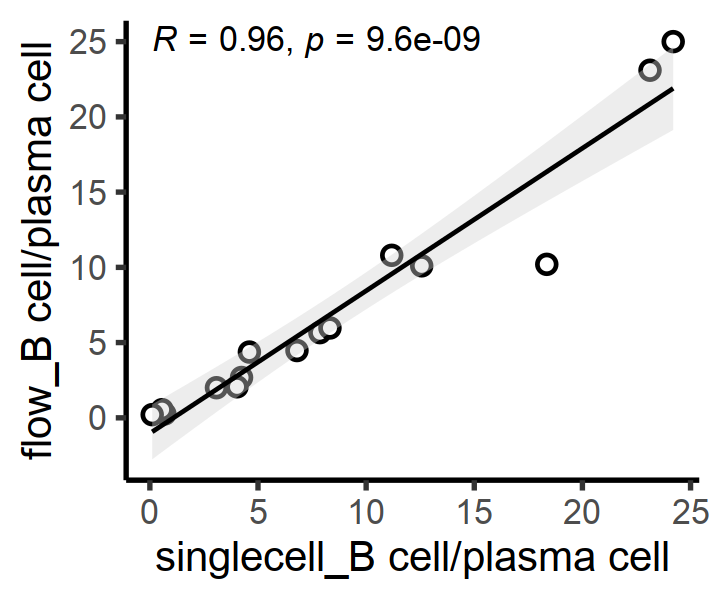

`geom_smooth()` using formula 'y ~ x'



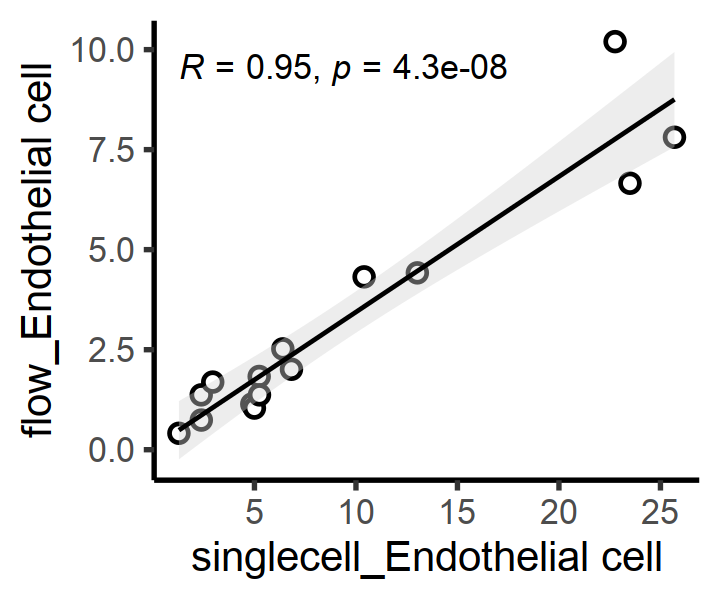

`geom_smooth()` using formula 'y ~ x'



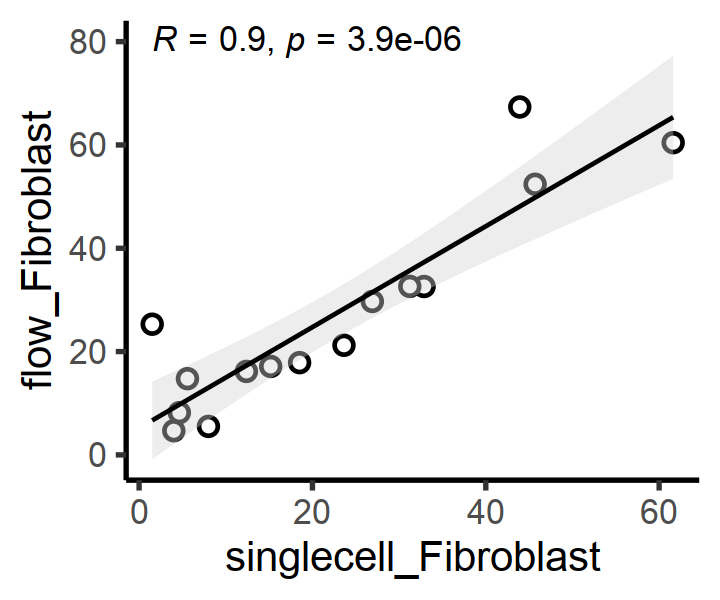

`geom_smooth()` using formula 'y ~ x'



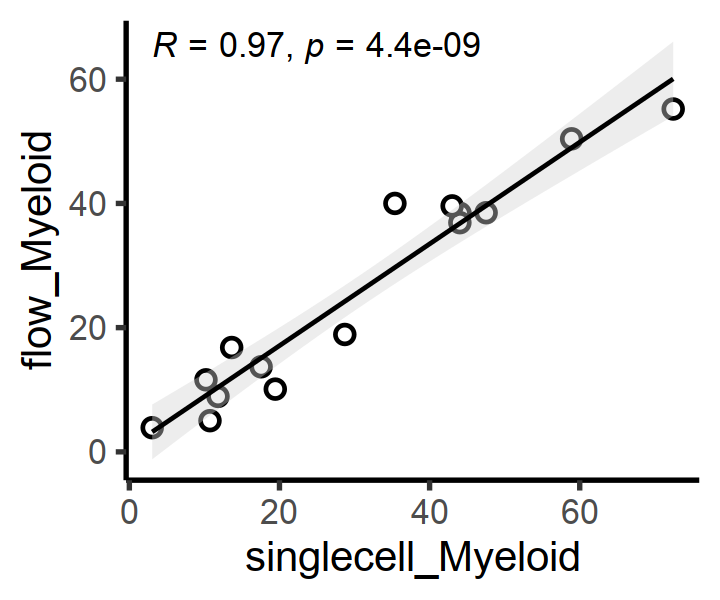

`geom_smooth()` using formula 'y ~ x'



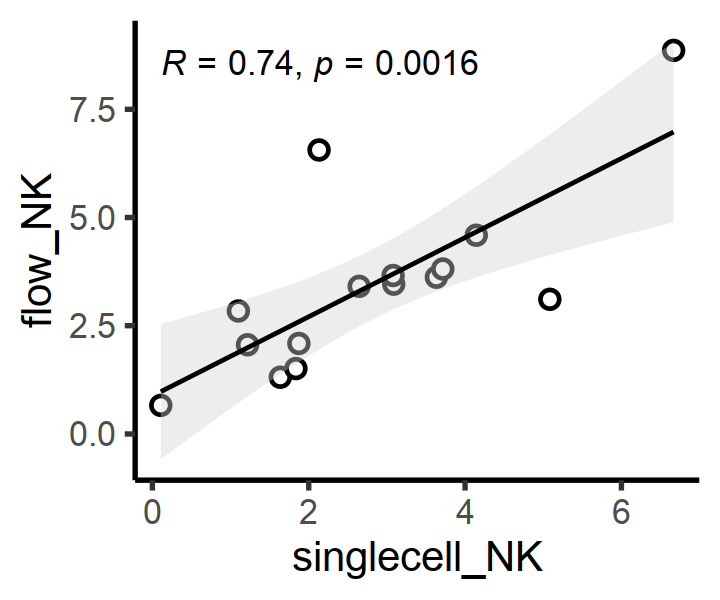

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



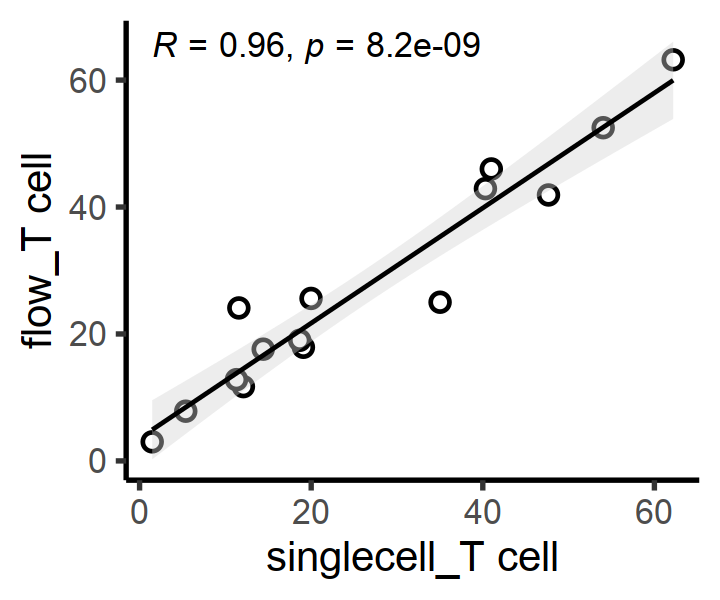

In [90]:
#  Updated NK
options(repr.plot.width = 6, repr.plot.height = 5)
p1
p2
p3
p4
p5
p6
ggsave(file = paste("ctaps_vs_flow_1", ".pdf", sep = ""), p1, width = 6, height = 5, dpi = 300)
ggsave(file = paste("ctaps_vs_flow_2", ".pdf", sep = ""), p2, width = 6, height = 5, dpi = 300)
ggsave(file = paste("ctaps_vs_flow_3", ".pdf", sep = ""), p3, width = 6, height = 5, dpi = 300)
ggsave(file = paste("ctaps_vs_flow_4", ".pdf", sep = ""), p4, width = 6, height = 5, dpi = 300)
ggsave(file = paste("ctaps_vs_flow_5", ".pdf", sep = ""), p5, width = 6, height = 5, dpi = 300)
ggsave(file = paste("ctaps_vs_flow_6", ".pdf", sep = ""), p6, width = 6, height = 5, dpi = 300)